# Assignment 4: Continuous time models

## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

# General instructions

1. Do not remove any text or code cells; do not leave redundent print messages.
1. When instructed to implement a function, use the given function names and parameters lists; failure to do so may cause test functions to fail during grading.
1. When instructed to generate a plot, make sure that the plot is clear, that axes are propely labeled, and that the notebook is saved with the plot inline, so that the grader can see the plot without running the code. Make sure that you re-generate the plot if you changed the code!
1. Code lines with a triple comment `###` should not be removed or modified, they are used for automatic grading.
1. Note that there are 4 exercises and the last cell in the notebook says **end of assignment**; if you are missing anything please download the origianl file from the course website.
1. Your code should run within a reasonable time (a few minutes) and you should use idioms learned in class, e.g. array opreations, numba, multiprocessig.
1. Questions regarding the exercises should be posted to the course forum at the designated group (i.e. "assignment4"). You can post questions anonymously. You can also visit the Office Hours, but please do not email the course staff with questions about the exercise.
1. Intructions for submitting the exercise are on the [course website](https://scicompy.yoavram.com/assignments).

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numba
import scipy.stats
from scipy.integrate import solve_ivp
import seaborn as sns
sns.set_context('notebook')
red, blue, green, purple, orange, yellow = sns.color_palette('Set1', 6)

# Background

Recall our work on the predator-prey model:

In [22]:
def dxydt(t, xy, b, h, ϵ, d):
    x, y = xy
    dx = b * x - h * x * y
    dy = ϵ * h * x * y - d * y
    return np.array([dx, dy])

In [23]:
b = 1
h = 0.005
ϵ = 0.8
d = 0.6

steps = 50000
XY = np.empty((2, steps))
XY[:,0] = 50, 100
dt = 0.001

for t_ in range(1, steps):
    XY[:,t_] = XY[:, t_-1] + dxydt(t_, XY[:, t_-1], b, h, ϵ, d) * dt
X, Y = XY
T = np.arange(0, steps*dt, dt)

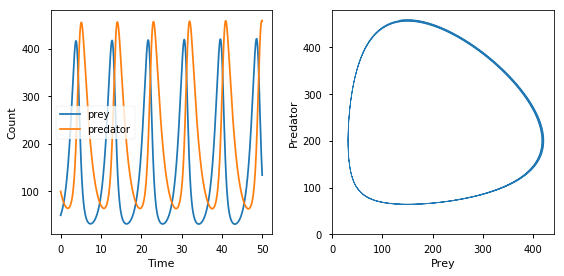

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.plot(T, X, label='prey')
ax.plot(T, Y, label='predator')
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.legend();

ax = axes[1]
ax.plot(X, Y, lw=0.5)
ax.set_xlabel('Prey')
ax.set_ylabel('Predator')
ax.set(xlim=(0, None), ylim=(0, None))

fig.tight_layout()

We talked about how these cycles only *seem* stable, but really, they are prone to extinctions due to stochastic events, leading to either exitinction of both species or extinction of the predator and explosion of the prey population.

In this assignment you will implement a stochastic simulation of the dynamics using Gillespie's algorithm, which we covered in lecture 10.

# Ex 1

**Write a table of reactions and their rates for the predator-prey dynamics**.

Note that this is not a coding exercise, but rather a written exercise: use Markdown/Latex to create the table.

$x$ denote the prey, $y$ denotes the predator; use the same rates as used in the deterministic model: $b$, $h$, $\epsilon$, and $d$.

Note that $h$ describes the rate at which predators hunts prey, whereas $\epsilon$ described the rate at which predators convert prey mass into predator mass.
We didn't have a scenario like that in the molecular dynamics case and it requires a bit of sophistication.

**WRITE THE REACTION TABLE HERE**

\begin{align}
\begin{array}{ll}
\text{reaction, }r_i & \text{rate, } a_i \\
x \rightarrow x+1, & \ bx \\
x \rightarrow x-1, & hxy\\
y \rightarrow y+1, \;\;\;\; & \epsilon hxy \\
y \rightarrow y-1, \;\;\;\; & dy
\end{array}
\end{align}

# Ex 2

**Write a Gillespie simulation for the predator-prey dynamics.**

**Run a single simulation and plot it together with the deterministic dynamics.**

Plot both prey and predator population sizes vs time, as well as a phase plot of the predator vs prey.

Note 1: once the predators are extinct there is no more use to continue running the simulation as the prey will just grow exponentiallt according to $dx/dt = bx$.

Note 2: since this is a stochastic simulation, your results may differ from mine.

In [7]:
@numba.jit # 2-fold faster
def get_rates(x, y, b, h, d, ϵ):
    return np.array([
        b * x,         # prey -  growth
        h * x * y,     # prey - death
        ϵ * h * x * y, # predator - growth
        d * y          # predator - death
    ])


In [8]:

@numba.jit # 2-fold faster
def draw_time(rates):
    total_rate = rates.sum()
    return np.random.exponential(1/total_rate)

def draw_reaction(rates):
    rates /= rates.sum()
    return np.random.multinomial(1, rates).argmax()

updates = np.array([
    [1, 0],  # prey -  growth
    [-1, 0], # prey - death
    [0, 1],  # predator - growth
    [0, -1]  # predator - death
])





In [9]:


def gillespie_step(x, y, b, h, d, ϵ):
    rates = get_rates(x, y, b, h, d, ϵ)
    Δt = draw_time(rates)
    ri = draw_reaction(rates)
    Δx, Δy = updates[ri]
    return Δt, Δx, Δy

def gillespie_ssa(b, h, d, ϵ, t0=0, x0=1, y0=1, t_steps=1000, tmax=10):
    times = np.linspace(t0, tmax, t_steps) # recording times: time points in which to record the state
    states = np.empty((updates.shape[1], t_steps), dtype=int) # recorded states
    
    
    # init
    t = t0
    x, y = x0, y0
    Δx, Δy = 0, 0
    # loop over recording times
    for i, next_t in enumerate(times):
        # simulate until next recording time
         while t < next_t:
            if y == 0:
                Δt, Δx, Δy = 1, 0, 0
            else:
                Δt, Δx, Δy = gillespie_step(x, y, b, h, d, ϵ)
            t, x, y = t+Δt, x+Δx, y+Δy
        # record the previous state for the time point we just passed
         states[:, i] = x - Δx, y - Δy
                
    return np.concatenate((times.reshape(1, -1), states), axis=0)

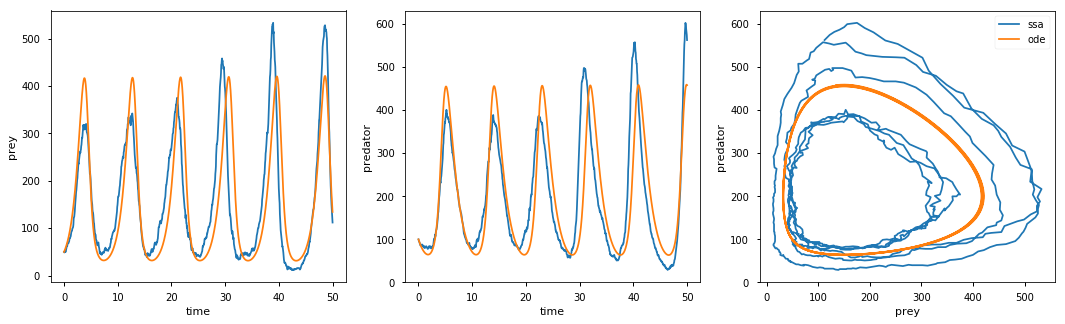

In [21]:
t, x, y = gillespie_ssa(b, h, d, ϵ, x0=50, y0=100, tmax=50)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ax = axes[0]
ax.plot(t, x, label='ssa')
ax.plot(T, X, label='ode')
ax.set_xlabel('time')
ax.set_ylabel('prey')

ax = axes[1]
ax.plot(t, y, label='ssa')
ax.plot(T, Y, label='ode')
ax.set_xlabel('time')
ax.set_ylabel('predator')

ax = axes[2]
ax.plot(x, y, label='ssa')
ax.plot(X, Y, label='ode')
ax.set_xlabel('prey')
ax.set_ylabel('predator')

ax.legend();



# Ex 3

**Calculate the extinction probability of the predators in the first 50 days (assuming `t` is in days) and plot it as a function of $h$ the hunting probability.**

The extinction probability is the probability that the predators populations size reaches zero.
To do that, you will have to run many simulations for the same parameters and check what is the fraction that finished with zero predators.

Think: How many replications should you use per parameter set?
Remember that the standard error of the mean generally decreases like the root of the number of observations ($\sqrt{n}$).

When choosing the number of $h$ values, think if you want to use `np.linspace` or `np.logspace`, or maybe draw random values (from which distribution?) and how many points you should use.

Note that this exercise will require running many simulations; if we estimate the probability from just 100 simulations, and plot against just 10 values of $h$, we still need to run 1000 simulations.

There are several ways to attack this, and they are not mutually exclusive:
1. optimize the simulation code
1. run in parallel on multiple cores on your own machine (see end of lecture 10).
1. use cloud computing on your own (see end of lecture 10).
1. use the [course's cloud computing](https://scicompy-jupyter.yoavram.com) as explained in class. Remember that this is a shared resource for all course participants, so try to use it when it is free.

At any case, make sure to save your simulation results to files so that you can reload them again and change the analysis or plot the figure again (but do not include these files in the assignment submission).

In [19]:
from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor, as_completed
import warnings

In [20]:
# checked it on the cloud but the plot here is from local running with 600 reps and not 6000 , since it killed my CPU

num_of_cpus=cpu_count()
reps = 6000

def simulation(h_):
    pred_extinct_counter = 0
    kwargs = dict(b=b ,h=h_ ,ϵ=ϵ, d=d, t_steps=reps, tmax=50)
    with ProcessPoolExecutor(num_of_cpus) as exec:
        futs = [exec.submit(gillespie_ssa, **kwargs) for i in range(reps)]

    for cur_finished_thread in as_completed(futs):
        if cur_finished_thread.exception():
            warnings.warn(str(cur_finished_thread.exception()))
        else:
            result_gillespie_ssa = cur_finished_thread.result()
            if result_gillespie_ssa[2][-1] == 0:
                pred_extinct_counter = pred_extinct_counter + 1
    return pred_extinct_counter/reps

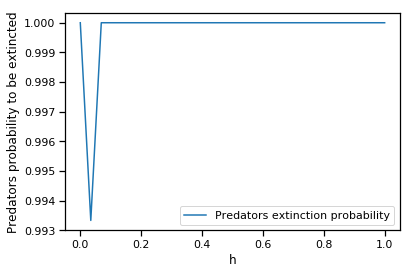

In [24]:
number_of_reps = 30
h_arr = np.linspace(np.power(0.1,5),1,number_of_reps)
results = np.empty((2, number_of_reps))
counter = 0
for h in h_arr:
    results[:,counter]= (h,simulation(h))
    counter = counter + 1
      

plt.plot(results[0], results[1],label='Predators extinction probability')
plt.xlabel('h')
plt.ylabel('Predators probability to be extincted')
plt.legend();




# Ex 4

Here's data from a real predator-prey system -- the hare and lynx system:

In [4]:
data = np.fromstring("""0 20 10 
2 55 15 
4 65 55 
6 95 60 
8 55 20 
10 5 15 
12 15 10 
14 50 60 
16 75 60 
18 20 10 
20 25 5 
22 50 25 
24 70 40 
26 30 25 
28 15 5 
""", sep=' ', dtype=int)
data = data.reshape(-1, 3)
data[:, 1] *= 1000
data[:, 2] *= 100
print(data)

[[    0 20000  1000]
 [    2 55000  1500]
 [    4 65000  5500]
 [    6 95000  6000]
 [    8 55000  2000]
 [   10  5000  1500]
 [   12 15000  1000]
 [   14 50000  6000]
 [   16 75000  6000]
 [   18 20000  1000]
 [   20 25000   500]
 [   22 50000  2500]
 [   24 70000  4000]
 [   26 30000  2500]
 [   28 15000   500]]


The first column is years, the second is hare population size, the third is lynx population size.

Here is a plot the data.

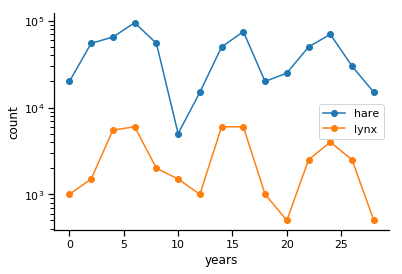

In [5]:
t, hare, lynx = data.T

plt.plot(t, hare, '-o', label='hare')
plt.plot(t, lynx, '-o', label='lynx')
plt.yscale('log')
plt.xlabel('years')
plt.ylabel('count')
plt.legend()

sns.despine()

We can see the cycles that we discussed in lecture 10.

**Now use ABC to fit a model to the data**, just as we did in lecture 11.

Do not use summary statistics, rather, calculate the MSE (mean squared error) between the data and the simulations.
The `ABCSMC` constructor's third argument is a distance function that accepts the simulation dict as a first argument and the real dict as a second argument (the real dict is the one you give to the `new` method later on). See [example](https://pyabc.readthedocs.io/en/latest/examples/parameter_inference.html).

**Tips**
- for `b` and `d` choose an `expon(1)` prior distribution
- for `h` and `ϵ` choose `uniform(0, 1)` prior distribution
- if you get division by zero errors, the population has probably gone extinct, you should make sure you stop the simulation when the population is extinct
- running time may vary, but will take at least several minute

In [18]:
from pyabc import ABCSMC, RV, Distribution
from pyabc.visualization import plot_kde_1d, plot_kde_2d
import os
import tempfile

In [10]:
def model(params):
    # run a single simulation
    t, x, y = gillespie_ssa(params.b, params.h, params.d, params.ϵ, t_steps=15)

    return dict( ###
        t_ = t, prey_ = x, predator_ = y
    ) ###

prior = Distribution( ###
    # set the parameter prior distributions here
    b=RV("expon", 1), 
    d=RV("expon", 1),     
    h=RV("uniform", 0, 1),
    ϵ=RV("uniform", 0, 1)
) ###

def mse(x, y): ###
    # compute the distance between data and simulation (distance is symmetric so it doesn't matter which is x and which is y)
    simulation = np.array([x['prey_'], x['predator_']])                    
    actual = np.array([y['prey_'], y['predator_']])
    return np.square(simulation - actual).mean()
    
    
# create the ABC object and init it with the new method
abc = ABCSMC(model, prior,mse)

abc.new("sqlite:///" + os.path.join(tempfile.gettempdir(), "newfile.db"), {"t_": t, "prey_": hare, "predator_": lynx})

INFO:History:Start <ABCSMC(id=2, start_time=2019-01-08 15:12:55.187723, end_time=None)>
INFO:Epsilon:initial epsilon is 1260081933.8666666


2

In [17]:
%%time
minimum_epsilon = 1260081933.86
max_nr_populations = 4
history = abc.run(minimum_epsilon=minimum_epsilon, max_nr_populations=max_nr_populations)

INFO:ABC:t:5 eps:1259075533.9328074
INFO:History:Done <ABCSMC(id=2, start_time=2019-01-08 15:12:55.187723, end_time=2019-01-08 15:17:04.317900)>


CPU times: user 2.41 s, sys: 209 ms, total: 2.62 s
Wall time: 1min 1s


We now plot the approximated posterior distributions of the model parameters.

In [14]:
params, weights = history.get_distribution(0)
params.head()

name,b,d,h,ε
id,,,,
303,6.218081,3.076677,0.676256,0.185261
304,7.300360,2.742486,0.634741,0.452300
305,6.394534,4.007348,0.446863,0.280960
306,10.170940,4.856877,0.847391,0.117095
307,4.470765,3.126042,0.730318,0.383313


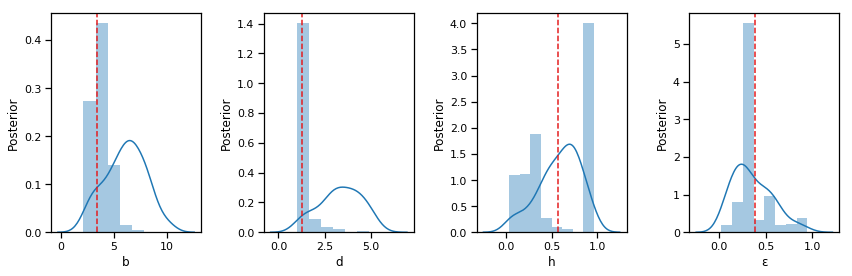

In [25]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for param_name, ax in zip(params.columns, axes.flat):
    sns.distplot(params[param_name], hist_kws=dict(weights=weights), ax=ax)
    ax.axvline(params[param_name].values @ weights, color=red, ls='--')
    ax.set(xlabel=param_name, ylabel='Posterior')

fig.tight_layout()

**end of assignment**